# Rainfall runoff prediction

In [1]:
import geopandas as gpd
import matplotlib.pyplot as plt
import os
import xarray as xr
import pandas as pd
import tensorflow as tf
import numpy as np
import matplotlib.dates as mdates
from libs import generator

In [2]:
model_dir = "./models"
data_dir = "./data"
basin_path = os.path.join(data_dir, "wv_catchment.geojson")
subbasin_path = os.path.join(data_dir, "wv_subbasins.geojson")
gauges_path = os.path.join(data_dir, "gauges.geojson")
streamflow_path = os.path.join(data_dir, "discharge_timeseries.csv")
# dams_path = "./data/wv/dams.geojson"

plt.style.use('seaborn-ticks')

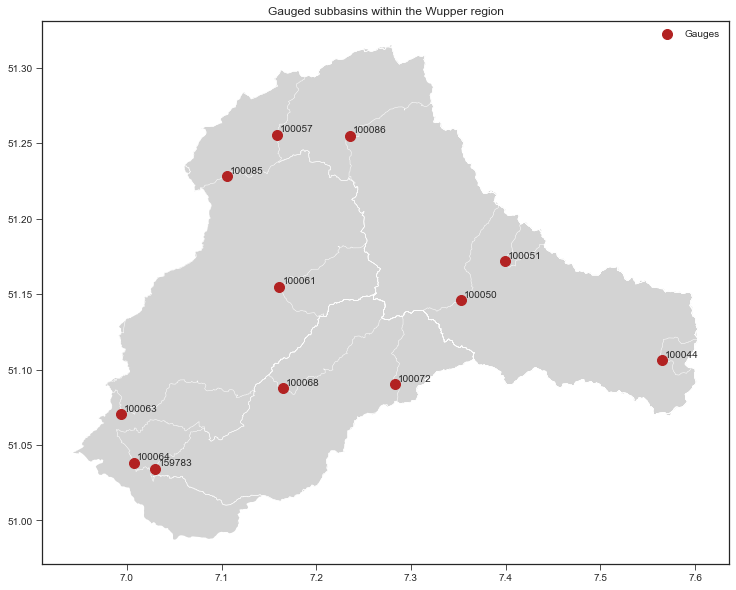

In [3]:
# Read geospatial data
gpd_catchment = gpd.read_file(basin_path)
gpd_subbasins = gpd.read_file(subbasin_path)
gpd_gauges = gpd.read_file(gauges_path)

fig, ax = plt.subplots(figsize=(16, 10))
ax.set_aspect('equal')
gpd_catchment.plot(ax=ax, color='lightgrey')
gpd_subbasins.plot(ax=ax, color="none", linewidth=0.5, edgecolor='white')
gpd_gauges.plot(ax=ax, marker='o', markersize=100, color='firebrick', label="Gauges")
# dams.plot(ax=ax, color="steelblue")
ax.set_title("Gauged subbasins within the Wupper region")
ax.legend()

for x, y, label in zip(gpd_gauges.geometry.x, gpd_gauges.geometry.y, gpd_gauges.id):
    ax.annotate(label, xy=(x, y), xytext=(3, 3), textcoords="offset points", fontsize=10)

In [4]:
gpd_gauges

,fid,id,name,geometry
0,4,100044,Stöcken,POINT (7.56467 51.10604)
1,9,100050,Hückeswagen,POINT (7.35244 51.14584)
2,10,100051,Müllensiepen,POINT (7.39946 51.17167)
3,16,100057,Kluserbrücke,POINT (7.15852 51.25560)
4,20,100061,Kellershammer,POINT (7.16112 51.15485)
5,22,100063,Opladen,POINT (6.99416 51.07022)
6,23,100064,Manfort,POINT (7.00742 51.03828)
7,26,100068,Markusmühle,POINT (7.16515 51.08764)
8,30,100072,Neumühle,POINT (7.28300 51.09030)
9,43,100085,Rutenbeck,POINT (7.10539 51.22819)


In [5]:
path = "D:/Dokumente/Promotion/01_Data/DWD/REGNIE/netcdf/wv_regnie.nc"
xds_regnie = xr.open_dataset(path)

pd_streamflow = pd.read_csv(streamflow_path, sep=",", skiprows=2, header=0, decimal=".")
pd_streamflow["date"] = pd.to_datetime(pd_streamflow["date"])
pd_streamflow = pd_streamflow.rename(columns={"date": "time"})
pd_streamflow = pd_streamflow.melt(id_vars=["time"], var_name="basin", value_name="streamflow")
pd_streamflow = pd_streamflow.set_index(["time", "basin"])
ds_streamflow = pd_streamflow.to_xarray()

xds_merge = xds_regnie.merge(ds_streamflow)

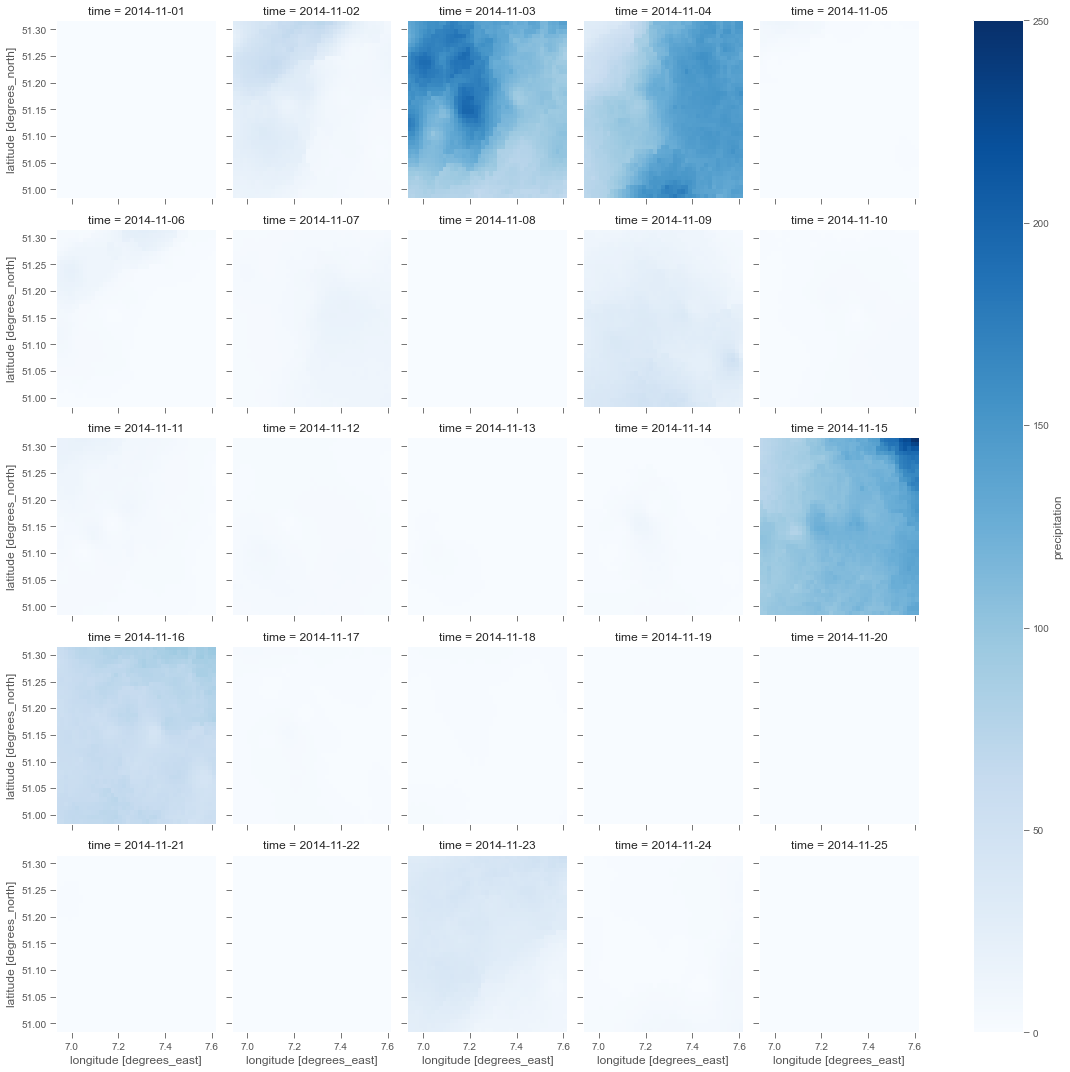

In [6]:
plt.style.use('ggplot')
xd_prcp = xds_merge.sel(time=slice("2014-11-01", "2014-11-25")).precipitation
g = xd_prcp.plot(col="time", col_wrap=5, cmap=plt.cm.Blues)

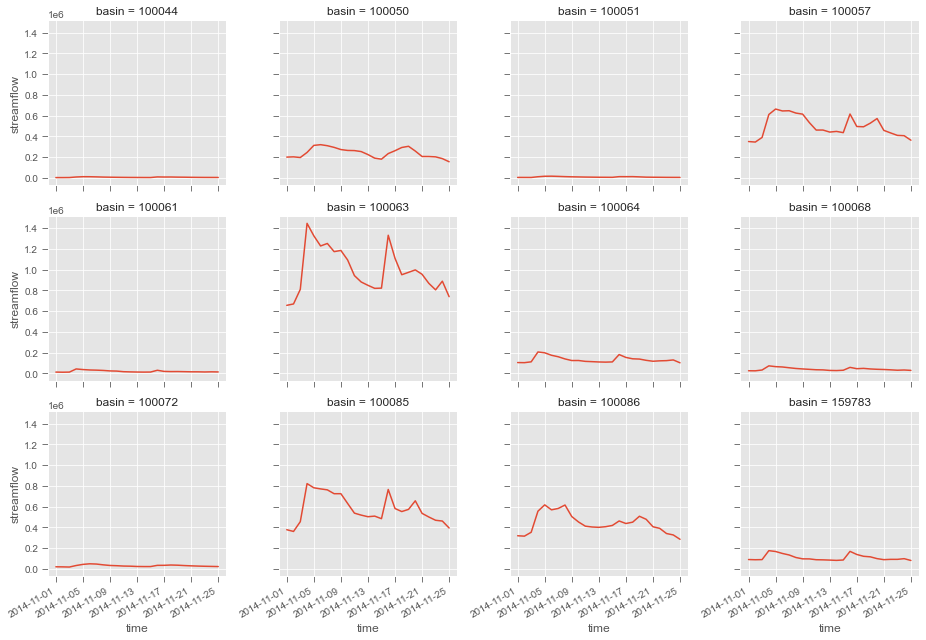

In [7]:
xd_streamflow = xds_merge.sel(time=slice("2014-11-01", "2014-11-25")).streamflow
g = xd_streamflow.plot(col="basin", col_wrap=4)

## Model evaluation
### Prepare test dataset

In [8]:
# Split datasets
sample_basins = ["100050", "100044", "100057", "100064", "100051", "100072", "100063"]
out_of_sample_basins = ["100061", "100068", "100085", "159783", "100086"]

feature_vars = ["precipitation"]
target_var = "streamflow"
train_start_date = "1990-01-01"
train_end_date = "2010-12-31"
test_start_date = "2016-01-01"
test_end_date = "2020-12-31"
timesteps = 10
batch_size = 32
offset = 1

train_xds = xds_merge.sel(basin=sample_basins, time=slice(train_start_date, train_end_date))
test_xds = xds_merge.sel(basin=sample_basins, time=slice(test_start_date, test_end_date))

# Apply min/max scaling by using min and max from training dataset
xds_min = train_xds.min()
xds_max = train_xds.max()

test_xds = (test_xds - xds_min) / (xds_max - xds_min)

# Eavaluate
eval_timesteps = 10

test_gen = generator.CustomTimeseriesGenerator(xds=test_xds, batch_size=batch_size, timesteps=eval_timesteps,
                                               offset=offset, feature_vars=feature_vars, target_var=target_var,
                                               drop_na=False, joined_output=True)


### Predict and evaluate

In [9]:
model = tf.keras.models.load_model("./models/20220401173449_wv_bulk.h5")

predictions = model.predict(test_gen)

target_start_date = np.datetime64(test_start_date) + np.timedelta64(eval_timesteps, 'D') + np.timedelta64(offset, 'D') - np.timedelta64(1, 'D')
res_time = test_xds.sel(time=slice(target_start_date, np.datetime64(test_end_date))).time

xds_prediction = xr.Dataset({"streamflow": (["time", "basin"], predictions)}, coords={"time": res_time, "basin": test_xds.coords["basin"].values})

xds_prediction = xds_prediction * (xds_max - xds_min) + xds_min
test_xds_resc = test_xds * (xds_max - xds_min) + xds_min

xds_obs = test_xds_resc.rename({"streamflow": "streamflow_obs"})
xds_prediction = xds_prediction.rename({"streamflow": "streamflow_pred"})
xds_result = xr.merge([xds_prediction, xds_obs], join="left")

predictions = xds_result["streamflow_pred"]
observations = xds_result["streamflow_obs"]

xda_nse = 1 - xr.DataArray.sum((predictions - observations) ** 2, dim="time") / xr.DataArray.sum((observations - observations.mean(dim="time")) ** 2, dim="time")
xds_result = xds_result.assign(nse=xda_nse)


In [10]:
xds_result

<xarray.Dataset>
Dimensions:          (time: 1817, basin: 7, x: 41, y: 40)
Coordinates:
  * time             (time) datetime64[ns] 2016-01-11 2016-01-12 ... 2020-12-31
  * basin            (basin) object '100050' '100044' ... '100072' '100063'
  * x                (x) float64 6.942 6.958 6.975 6.992 ... 7.575 7.592 7.608
  * y                (y) float64 50.99 51.0 51.0 51.01 ... 51.29 51.3 51.3 51.31
Data variables:
    streamflow_pred  (time, basin) float64 3.351e+05 1.69e+04 ... 1.728e+06
    precipitation    (time, y, x) float64 76.0 75.0 80.0 80.0 ... 16.0 17.0 17.0
    spatial_ref      float64 nan
    streamflow_obs   (time, basin) float64 6.451e+05 1.54e+04 ... 1.359e+06
    nse              (basin) float64 0.625 -0.9642 0.6124 ... 0.6039 0.6564

In [11]:
def plot_hydrograph(xds, basin):
    fig, ax = plt.subplots(figsize=(16, 10))
    xds.sel(basin=basin)["streamflow_pred"].plot(ax=ax, label="prediction", zorder=1)
    xds.sel(basin=basin)["streamflow_obs"].plot(ax=ax, label="observation", zorder=0)
    ax.set_xlabel("time")
    ax.set_ylabel("streamflow")
    ax.xaxis.set_major_formatter(mdates.DateFormatter("%Y-%b"))
    ax.set_title(f"Basin: {basin}")
    ax.legend()

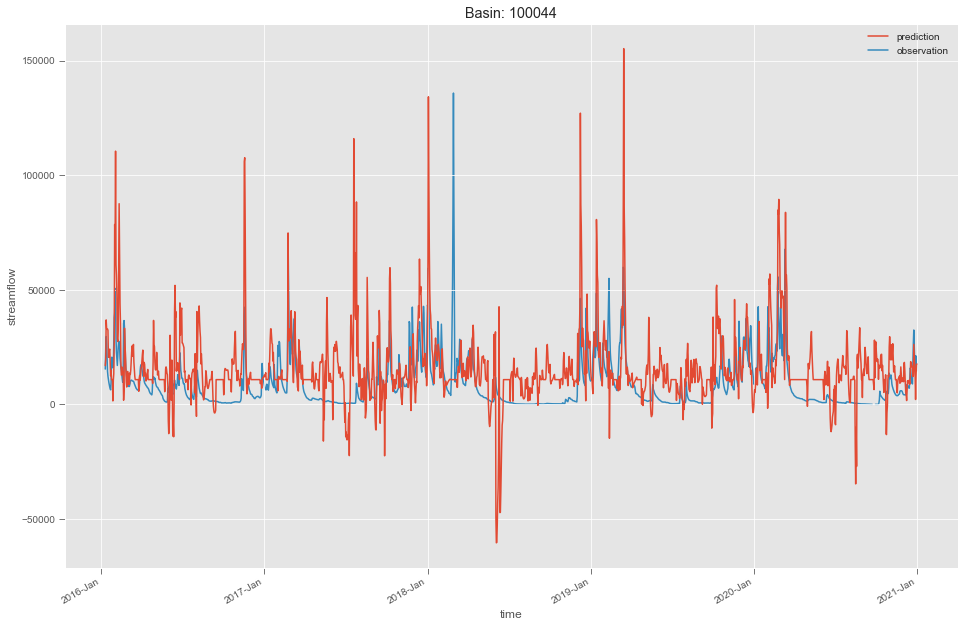

In [12]:
plot_hydrograph(xds_result, sample_basins[1])